# Notæ 3 

## PLE y problemas de optimización en grafos

### Introducción

Los problemas provenientes de la optimización de recursos muchas veces pueden ser modelados como problemas de optimización en grafos. Generalmente, estos problemas pertenecen a la clase NP-difícil, por lo que no se esperan encontrar algoritmos eficientes que permitan resolver todas las instancias. No obstante, contar con algoritmos que resuelvan al menos instancias pequeñas es una herramienta fundamental para complementar el estudio teórico. Mediante ellos, es posible poner a prueba conjeturas, verificar resultados obtenidos analíticamente, delegar al software actividades mecánicas, etc. 

El diseño de algoritmos específicos para resolver un problema no es un trabajo sencillo y en general requiere un gran esfuerzo. Por otro lado, una enumeración exhaustiva de las soluciones rápidamente se puede volver computacionalmente intratable incluso en instancias pequeñas. 

En este contexto, la Programación Lineal Entera (PLE) ha tomado un amplio protagonismo en el diseño de algoritmos. Esto se debe a que su sencillo formalismo es capaz de modelar un gran número de problemas de optimización. Otro factor que ha contribuido es el surgimiento de softwares de optimización: CPLEX, Gurobi, etc., los cuales cuentan con potentes algoritmos para resolver PLE de una forma prácticamente transparente para el usuario.

Por estos motivos, la PLE es una herramienta fundamental en nuestra área y suele ser una de las primeras opciones a la hora de diseñar algoritmos para problemas difíciles.

El objetivo de este notebook es aprender a escribir y resolver en Python formulaciones de PLE que modelen problemas de optimización en grafos, donde las variables y restricciones dependan de ciertas estructuras de grafo, tales como, vértices, aristas, vecindades, cliques, conjuntos estables, entre otras.

&#9940; Alto &#9940; No avanzar hasta haber leído los notebooks 1 y 2.

### Caso de estudio

Seguiremos como caso de estudio el problema de coloreo de vértices. Este problema es ampliamente conocido en el área debido a todas sus aplicaciones, por ejemplo, en problemas de scheduling, de asignación de aulas, de alocación de registros, etc. Antes necesitaremos algunas definiciones.

<b>Definición.</b> Dado un grafo $G = (V,E)$ y un conjunto de colores $\mathcal C$, un coloreo de $G$ es una función $f : V \to \mathcal C$ que asigna a cada vértice de $V$ un color de $\mathcal C$ tal que vértices adyacentes tengan asignados colores distintos, es decir, para toda arista $uv \in E$, $f(u) \neq f(v)$.

<b>Observación.</b> Dado un coloreo $f$ de $G$ y un color $k \in \mathcal C$, $f^{-1}(k)$ es el conjunto de vértices coloreados con $k$.

<b>Definición.</b> Dado un coloreo $f$ de $G$, $\mathcal A_f = \{k \in \mathcal C: f^{-1}(k) \neq \emptyset\}$ es el conjunto de colores usados por $f$. 

Ahora sí, podemos formular el problema de la siguiente forma:

<b>Problema de coloreo de vértices.</b><br>
<b>Entrada:</b> Un grafo $G$.<br>
<b>Objetivo:</b> Hallar un coloreo $f$ de $G$ con mínimo $|\mathcal A_f|$.

Existen muchas formulaciones en la literatura que modelan este problema. Nosotros seguiremos la usada por <a href="https://www.sciencedirect.com/science/article/pii/S0166218X0700100X#bib3">Isabel Méndez-Díaz y Paula Zabala (2008)</a>.

Esta formulación posee dos tipos de variables. Por un lado, están las variables binarias de asignación vértice-color, dado $v \in V$ y $k \in \mathcal C$, $x_{vk} = 1$ si y solo si $v$ se pinta con $k$. Por el otro, están las variables binarias de activación de color, dado $k \in \mathcal C$, $w_k = 1$ si el color $k$ se usa. 

La función objetivo consiste en minimizar el número de colores usados, es decir: 
<p>$$\min \sum_{k \in \mathcal C}w_k.$$</p>

La primer familia de restricciones fuerza a que cada vértice se pinte con exactamente un color:
<p>$$ \sum_{k \in \mathcal C} x_{vk} = 1, ~~~~ \forall~v \in V. $$</p>

La segunda familia de restricciones obliga a que dos vértices adyacentes tengan colores diferentes:
<p>$$ x_{vk} + x_{uk} \leq 1, ~~~~ \forall~vu \in E,~  k \in \mathcal C.$$</p>

Desafortunadamente, estas restricciones no son suficientes porque falta todavía forzar a que las variables de activación de color se activen cuando un color es usado (de lo contrario, el mínimo tendría valor objetivo igual a 0). Una idea para solucionar esto consiste en modificar la segunda familia de restricciones de la siguiente forma:
<p>$$ x_{vk} + x_{uk} \leq w_k, ~~~~ \forall~vu \in E,~  k \in \mathcal C.$$</p>

Así, si uno de los extremos de la arista se pinta con $k$, entonces estas restricciones fuerzan a que $w_k = 1$. A su vez, dado que $w_k$ es binaria, es decir, $w_k \in \{0,1\}$, las restricciones siguen prohibiendo que ambos extremos se pinten con $k$.

<b>Nota 1.</b> Nada evita que las variables de activación de color se prendan para colores no usados. Por eso, cuando definimos las variables $w_k$, no usamos un "si y sólo si". Esto implica que el modelo tiene soluciones factibles que no representan coloreos válidos. Sin embargo, estas soluciones nunca serán óptimas porque siempre podemos encontrar una solución con menor valor objetivo al apagar los colores no usados.

<b>Nota 2.</b> Esta formulación no sirve para grafos sin aristas. Si bien es posible arreglarla agregando restricciones de la forma, $x_{vk} \leq w_k$ para todo vértice $v$ aislado y color $k$, no vamos a complicar la formulación porque el problema de coloreo de vértices es trivial de resolver en esas instancias.

### Modelado en Python

Empezamos el modelado importando los paquetes que vamos a necesitar:

In [1]:
from docplex.mp.model import Model
import networkx as nx

Primero, vamos a escribir nuestro modelo para una instancia particular y posteriormente lo vamos a generalizar. Supongamos que queremos colorear el grafo de Petersen:

In [2]:
Petersen = nx.petersen_graph()

Ahora, inicializamos nuestro modelo:

In [3]:
modelo_petersen = Model(name='coloreo_petersen')

A continuación, definimos el conjunto de colores. Cada color lo vamos a representar con un número entero no negativo. A priori, podriamos usar tantos colores como vértices tenga el grafo. Sin embargo, es sabido que todo grafo $G$ se puede colorear con a lo sumo $\Delta(G)+1$ colores, es decir, a lo sumo un color más que el máximo grado de $G$. Luego podemos restringir los colores al conjunto $\{0,\ldots,\Delta(G)\}$. 

Entonces, tenemos que escribir una función <code>max_grado</code> que tome un grafo y retorne el máximo grado. Existen muchas formas de hacer esto, veamos una sencilla... Primero construimos una lista con el grado de todos los vértices del grafo. Luego, retornamos el máximo de esa lista:

In [4]:
def max_grado(G):
    grados = [G.degree(v) for v in G]
    return max(grados)

Testeamos nuestra función en el grafo de Petersen definido más arriba:

In [5]:
max_grado(Petersen)

3

Ahora sí podemos definir el conjunto de colores. Recordar que la función de python <code>range(a,b)</code> representa el conjunto $\{a,\ldots,b-1\}$.

In [6]:
C = range(0,max_grado(Petersen) + 1)

Procedemos a agregar las variables al modelo. Generamos las variables de asignación vértice-color $x_{vk}$ para todo vértice $v$ y color $k$. Lo hacemos en una única línea de la siguiente forma:

In [7]:
X = [[modelo_petersen.binary_var(name='x_' + str(v) + '_' + str(k)) for k in C] for v in Petersen]

Generamos las variables de activación de color $w_k$ para todo color $k$:

In [8]:
W = [modelo_petersen.binary_var(name='w_' + str(k)) for k in C]

Una vez listas las variables, pasamos a escribir la función objetivo:
<p>$$\min \sum_{k \in \mathcal C}w_k.$$</p>

In [9]:
modelo_petersen.minimize(modelo_petersen.sum(W[k] for k in C))

Ahora, agregamos las restricciones de asignación de color:
<p>$$ \sum_{k \in \mathcal C} x_{vk} = 1, ~~~~ \forall~v \in V. $$</p>

In [10]:
for v in Petersen:
    modelo_petersen.add_constraint(modelo_petersen.sum(X[v][k] for k in C) == 1)

Por último, las restricciones de adyacencia:
<p>$$ x_{vk} + x_{uk} \leq w_k, ~~~~ \forall~vu \in E,~  k \in \mathcal C.$$</p>

In [11]:
for u, v in Petersen.edges:
    for k in C:
        modelo_petersen.add_constraint(X[u][k] + X[v][k] <= W[k])

El número de variables es $|V|.|\mathcal C| + |\mathcal C|$ y el número de restricciones es $|V| + |E|.|\mathcal C|$.

¡Listo! Nos resta resolver el modelo:

In [12]:
sol = modelo_petersen.solve(log_output=True)

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
Reduced MIP has 70 rows, 44 columns, and 220 nonzeros.
Reduced MIP has 44 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.12 ticks)
Found incumbent of value 4.000000 after 0.01 sec. (0.30 ticks)
Probing time = 0.00 sec. (0.03 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 70 rows, 44 columns, and 220 nonzeros.
Reduced MIP has 44 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.25 ticks)
Probing time = 0.00 sec. (0.03 ticks)
Clique table members: 70.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.20 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap



Al interpretar un poco el log, viendo la columna Best Integer sabemos que CPLEX logra encontrar con sus heurísticas una solución factible de valor 4, en la primera fila. Inmediatamente después encuentra con sus heurísticas una mejor solución factible con valor 3 (de hecho es la óptima pero todavía no lo puede probar). Viendo la columna Best Bound, en la 3er fila vemos que al resolver la relajación lineal tiene una cota inferior con valor 2. En las siguientes dos filas, se dedica a agregar planos de cortes, mediante los cuales logra ajustar la relajación lineal y obtener una cota inferior de valor 3. En este punto, ambas cotas coinciden, el gap se cierra y se logra probar la optimalidad. En este caso, no fue necesario hacer branching.

Para ahorrarnos tiempo, CPLEX provee algunos métodos para observar ciertos resultados de interés en el log. Por ejemplo, podemos imprimir el atributo <code>solve_details</code> de la clase <code>Model</code> para obtener un resumen final:

In [13]:
print(modelo_petersen.solve_details)

status  = integer optimal solution
time    = 0.148135 s.
problem = MILP
gap     = 0%



Además, podemos usar el método <code>get_objective_value()</code> de la clase <code>SolveSolution</code> para recuperar el valor óptimo:

In [14]:
sol.get_objective_value()

3.0

Es hora de generalizar el modelo para un grafo cualquiera dado de entrada. Esto lo logramos poniendo todo el código adentro de una función que tome como argumento la entrada de nuestro problema, que en el caso del problema de coloreo de vértices, es únicamente un grafo $G$. Dentro de la función, repetimos todo el código escrito anteriormente, procurando reemplazar cada aparición de la variable <code>Petersen</code> por <code>G</code>. También, renombramos algunas variables para hacer evidente que ya no es un modelo específico para Petersen, sino para cualquier grafo. Por otro lado, incluimos dos mejoras a nuestro programa:
1. Controlamos que se haya encontrado solución. La keyword <code>assert</code> de Python se ocupa de corroborar que la condición que le sigue sea cierta (en particular, que la solución no sea vacía). En caso de que la condición sea falsa, la ejecución se interrumpe y nos muestra en la pantalla un error con el mensaje que hayamos dejado luego de la coma.
2. Al finalizar, llamamos a una función <code>resumen</code>, cuya definición se encuentra más abajo, y se ocupa de imprimir por pantalla un resumen de los resultados.

In [18]:
def colorear(G):
    modelo = Model(name='coloreo') # Inicializamos el modelo 
    C = range(0,max_grado(G) + 2)  # Conjunto de colores
    
    # Variables
    X = [[modelo.binary_var(name='x_' + str(v) + '_' + str(k)) for k in C] for v in G]
    W = [modelo.binary_var(name='w_' + str(k)) for k in C]
    
    # Funcion objetivo
    modelo.minimize(modelo.sum(W[k] for k in C))
    
    # Restricciones
    for v in G:
        modelo.add_constraint(modelo.sum(X[v][k] for k in C) == 1)
    for u, v in G.edges:
        for k in C:
            modelo.add_constraint(X[u][k] + X[v][k] <= W[k])
    
    # Resolver modelo
    sol = modelo.solve() # No imprimimos el log
    
    assert sol, "No se encontró solución"
    
    # Imprimir resumen
    resumen(modelo, sol)
    
def resumen(modelo, sol):
    print(
        "Variables: ", modelo.number_of_variables, ", ",
        "Restricciones: ", modelo.number_of_constraints, ", ",
        "Estado: ", modelo.solve_details.status, ", ",
        "Tiempo: ", modelo.solve_details.time, "s, ",
        "Gap: ", modelo.solve_details.gap, ", ",
        "Valor: ", sol.get_objective_value()
    )

Ahora podemos aplicar nuestra función sobre cualquier grafo. Por ejemplo, para un grafo aleatorio de 10 vértices y probabilidad de arco 0.5: 

In [19]:
colorear(nx.erdos_renyi_graph(10, 0.5, seed=0))

Variables:  88 ,  Restricciones:  162 ,  Estado:  integer optimal solution ,  Tiempo:  0.008131980895996094 s,  Gap:  0.0 ,  Valor:  4.0


### &#x1f4bb; Actividad 1

En este actividad nos proponemos estudiar los límites de este modelo de coloreo en grafos aleatorios. Para cada probabilidad de arco $p \in \{0.25, 0.5, 0.75\}$, incrementar <u>progresivamente</u> el número de vértices y determinar el máximo tamaño de instancia que puede resolver en 60 segundos.

<b>Nota.</b> Para resolver esta actividad necesitará la versión full de CPLEX (sin el límite de 1000 variables y de 1000 restricciones).

In [20]:
# Celda para completar la Actividad 1

### &#x1f4bb; Actividad 2

En esta actividad trabajaremos con el problema de dominación de grafos. Antes, introducimos la siguiente definición:

<b>Definición.</b> Dado un grafo $G=(V,E)$ y un conjunto $D \subset V$, $D$ es un conjunto dominante de $G$ si todo vértice de $G$ está en $D$ o tiene algún vecino en $D$, es decir, para todo $v \in V$, $N[v] \cap D \neq \emptyset$.  

Luego, el problema de dominación se puede formular de la siguiente forma:

<b>Problema de dominación.</b><br>
<b>Entrada:</b> Un grafo $G$.<br>
<b>Objetivo:</b> Hallar un conjunto dominante $D$ de $G$ de cardinal mínimo.

1. Pensar en una formulación de PLE para el problema de dominación.
2. Usar lo aprendido en este Notebook para escribir una función <code>dominar(G)</code> que tome un grafo $G$, resuelva con CPLEX el modelo de PLE asociado a dicha instancia e imprima un resumen con los resultados.
3. Estudiar los límites del modelo en grafos aleatorios.

In [21]:
# Celda para completar la Actividad 2

### Testing

¿Cómo nos aseguramos de que la formulación de PLE que pensamos es correcta? Cuando la formulación es sencilla, muchas veces es trivial convencerse de que modela correctamente a nuestro problema, por ejemplo, la anterior para el coloreo de vértices. Sin embargo, en formulaciones más complejas, es habitual dar una prueba formal de que una solución óptima del programa lineal entero responde al objetivo de nuestro problema.

Sin embargo, esto no garantiza que al escribirlas a Python, las soluciones sean las esperadas. Por ejemplo, pudimos tipear mal alguna de las restricciones. Al igual que un error en la demostración de un teorema, un error en un programa es igual de grave y pueden llevarnos a falsas deducciones.

En esta sección, presentaremos algunas buenas prácticas de programación, herramientas y consejos que nos ayudarán a probar nuestros programas.

#### 1. Prestar atención a los errores de Python

Cuando Python encuentra un error, nos devuelve un <i>traceback</i> con información del lugar donde se produjo el error y el motivo. 

Por ejemplo, volvamos a nuestro modelo de coloreo sobre el grafo de Petersen. Recordemos que teníamos 4 colores, indexados de 0 al 3. Si al escribir la función objetivo, o alguna de las restricciones, queremos acceder a <code>W[4]</code>, entonces Python nos devolverá lo siguiente. Podemos ver que nos marca con "---->" el lugar donde se produjo el error y el motivo fue un índice fuera de rango.

In [22]:
W[4]

IndexError: list index out of range

Otro error común es equivocarnos en alguna restricción y que instancias que sabemos que son factibles sean reportadas como infactibles. 

Por ejemplo, considerar la siguiente función <code>colorear_rota</code> que construye mal el modelo de coloreo porque dice que las restricciones de arco son: 

$$x_{uk} + x_{vk} \leq 0 ~~~~ \forall u,v \in E,~ k \in \mathcal C$$

In [23]:
def colorear_rota(G):
    modelo = Model(name='coloreo') # Inicializamos el modelo 
    C = range(0,max_grado(G) + 2)  # Conjunto de colores
    
    # Variables
    X = [[modelo.binary_var(name='x_' + str(v) + '_' + str(k)) for k in C] for v in G]
    W = [modelo.binary_var(name='w_' + str(k)) for k in C]
    
    # Funcion objetivo
    modelo.minimize(modelo.sum(W[k] for k in C))
    
    # Restricciones
    for v in G:
        modelo.add_constraint(modelo.sum(X[v][k] for k in C) == 1)
    for u, v in G.edges:
        for k in C:
            modelo.add_constraint(X[u][k] + X[v][k] <= 0) # HAY UN ERROR EN ESTAS RESTRICCIONES
    
    # Resolver modelo
    sol = modelo.solve() # No imprimimos el log

    assert sol, "No se encontró solución"
    
    # Imprimir resumen
    resumen(modelo, sol)

Luego, al probar nuestra función tenemos la siguente salida.

In [24]:
colorear_rota(Petersen)

AssertionError: No se encontró solución

Sabemos que en el problema de coloreo de vértices toda instancia es factible. Por lo tanto, encontrar una infactible es evidencia suficiente para saber que nuestro programa tiene algún error.

#### 2. Escribir casos de prueba para nuestras funciones.

Al menos probar nuestras funciones en 3 o 4 casos y verificar que la respuesta sea la esperada.

Por ejemplo, para nuestra función <code>max_grado</code> podemos proponer los siguientes casos de prueba.

In [25]:
assert max_grado(Petersen) == 3
assert max_grado(nx.complete_graph(10)) == 9
assert max_grado(nx.cycle_graph(5)) == 2
assert max_grado(nx.star_graph(5)) == 5

#### 3. Contar número de variables y restricciones

Si conocemos el número de variables y restricciones que debería tener nuestro modelo, podemos compararlo con la cantidad que tiene en efecto.

Por ejemplo, recordemos que nuestra formulación de coloreo tenía $|V|.|\mathcal C| + |\mathcal C|$ variables y $|V| + |E|.|\mathcal C|$ restricciones. Luego para el modelo del grafo de Petersen, se tienen que cumplir las siguientes condiciones.

In [26]:
assert (Petersen.number_of_nodes() * len(C) + len(C)) == modelo_petersen.number_of_variables
assert (Petersen.number_of_nodes() + Petersen.number_of_edges() * len(C)) == modelo_petersen.number_of_constraints

#### 4. Revisar las soluciones encontradas en instancias chicas

Como ya mencionamos, la clase <code>SolveSolution</code> tiene el método <code>display()</code> para mostrar en pantalla la solución y su valor objetivo. 
    
Por ejemplo, para el grafo de Petersen se muestra lo siguiente.

In [27]:
sol.display()

solution for: coloreo_petersen
objective: 3
status: OPTIMAL_SOLUTION(2)
x_0_0 = 1
x_1_1 = 1
x_2_0 = 1
x_3_1 = 1
x_4_2 = 1
x_5_1 = 1
x_6_0 = 1
x_7_2 = 1
x_8_2 = 1
x_9_1 = 1
w_0 = 1
w_1 = 1
w_2 = 1


Por un lado, sabemos que el grafo de Petersen no se puede pintar con 2 colores (tiene un ciclo $C_5$ inducido). Falta ver entonces que la solución dada por CPLEX sea efectivamente un coloreo. Queda como actividad revisar manualmente esta solución. Recordar que las variables se interpretan de la siguiente forma: <code>x_0_0 = 1</code> significa que el vértice 0 se pinta de 0, <code>x_2_0 = 1</code> significa que el vértice 2 se pinta con 0, y así sucesivamente. También nos ayudará la función <code>draw_networkx(G)</code> de <code>networkx</code> para visualizar cómo se etiquetaron los vértices.

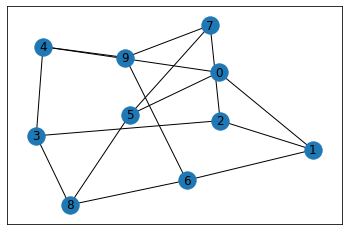

In [28]:
nx.draw_networkx(Petersen)

#### 5. Verificar computacionalmente las soluciones encontradas

Lógicamente en instancias más grandes ya no será posible verificar manualmente las soluciones. Pero podemos delegar esa tarea a la computadora. La idea es escribir una función que tome la solución encontrada y chequee que sea un coloreo.
    
¡Buenas noticias para quienes completaron el Notebook 2! Ya tenemos una función <code>es_coloreo(G,f)</code> que determina si $f$ es un coloreo de $G$. Quienes no lo hayan resuelto, es buen momento para volver al notebook y repensarlo. De todas formas, les dejamos una solución para que sigan avanzando.

In [29]:
def es_coloreo(G,f):
    for u,v in G.edges:
        if f[u] == f[v]:
            return False
    return True

Y sus casos de prueba:

In [30]:
assert es_coloreo(nx.path_graph(3), {0:0, 1:1, 2:0}) == True
assert es_coloreo(nx.path_graph(3), {0:0, 1:1, 2:1}) == False
assert es_coloreo(nx.complete_graph(4), {0:0, 1:1, 2:2, 3:3}) == True
assert es_coloreo(nx.complete_graph(4), {0:0, 1:1, 2:2, 3:0}) == False

Lo único que nos queda entonces es escribir una función que traduzca la solución de CPLEX a un diccionario de Python, que es el tipo de datos esperado por nuestra función <code>es_coloreo(G,f)</code>. 


Empecemos con el caso particular del grafo de Petersen. Primero, creamos un diccionario vacío.

In [31]:
coloreo_petersen = {}

Luego, iteramos sobre las variables de asignación vértice-color. Aquellas variables $x_{vk}$ que en la solución tengan valor 1, representan que $v$ se pinta con $k$. La clase <code>Var</code> posee un atributo <code>solution_value</code> que almacena el valor encontrado en la solución para esa variable. Por lo tanto, basta con preguntarnos si <code>X[v][k].solution_value == 1</code>. En ese caso, actualizamos esta información en el diccionario mediante la línea <code>coloreo_petersen[v] = k</code>. En la práctica no es conveniente comparar variables de CPLEX por igualdad (debido a aproximaciones numéricas), por lo que recomendamos comparar que sean mayores a cierto valor, típicamente 0.5 en variables binarias (total sus valores son muy cercanos a 0 o 1). 

In [32]:
for v in Petersen:
    for k in C:
        if X[v][k].solution_value >= 0.5:
            coloreo_petersen[v] = k

Finalmente, imprimimos el coloreo que resulta.

In [33]:
coloreo_petersen

{0: 0, 1: 1, 2: 0, 3: 1, 4: 2, 5: 1, 6: 0, 7: 2, 8: 2, 9: 1}

Ahora, movamos este código a una función <code>interpretar(G,C,X)</code> para que pueda ser aplicada sobre cualquier grafo $G$, conjunto de colores $\mathcal C$ y variables $X$.

In [34]:
def interpretar(G,C,X):
    coloreo = {}
    for v in G:
        for k in C:
            if X[v][k].solution_value >= 0.5:
                coloreo[v] = k
    return coloreo

Por último, definamos una función <code>chequear(G,C,X)</code> que se ocupe de interpretar la solución y chequear que sea un coloreo.

In [35]:
def chequear(G,C,X):
    coloreo = interpretar(G,C,X)
    assert es_coloreo(G,coloreo), "Error: no es coloreo"

<u>Recomendamos fuertemente incluir estos controles</u>. El mejor lugar para hacerlo es imediatamente después de haber resuelto el modelo y encontrado solución para la instancia. En nuestro ejemplo, redefinimos la función <code>colorear</code> para llamar a nuestra función <code>chequear(G,C,X)</code>.

In [36]:
def colorear(G):
    modelo = Model(name='coloreo') # Inicializamos el modelo 
    C = range(0,max_grado(G) + 2)  # Conjunto de colores
    
    # Variables
    X = [[modelo.binary_var(name='x_' + str(v) + '_' + str(k)) for k in C] for v in G]
    W = [modelo.binary_var(name='w_' + str(k)) for k in C]
    
    # Funcion objetivo
    modelo.minimize(modelo.sum(W[k] for k in C))
    
    # Restricciones
    for v in G:
        modelo.add_constraint(modelo.sum(X[v][k] for k in C) == 1)
    for u, v in G.edges:
        for k in C:
            modelo.add_constraint(X[u][k] + X[v][k] <= W[k])
    
    # Resolver modelo
    sol = modelo.solve() # No imprimimos el log

    assert sol, "No se encontró solución"    
    
    # Chequear solucion
    chequear(G,C,X)
    
    # Imprimir resumen
    resumen(modelo, sol)

Si, tener en cuenta todos estos controles al programar es molesto... Si, es trabajo extra... Pero les aseguro que es peor detectar meses después que había un error en el programa y que todos los resultados del último tiempo dejen de ser confiables (en lo personal, me ha pasado tener que volver a correr pruebas pesadas que toman varios días en ejecutarse por no haber invertido un par de líneas de código en controles).

### &#x1f4bb; Actividad 3

Incorporar a los desarrollos realizados en la Actividad 2 una función <code>interpretar(G,X)</code> que interprete los valores de las variables $X$ como un conjunto $D$ de vértices de $G$ y una función <code>es_dominante(G,D)</code> que verifica si $D$ es un conjunto dominante de $G$. 

<b>Nota.</b> Necesitará elegir una representación para el conjunto $D$, por ejemplo, puede ser una lista, un set o un diccionario de Python.

In [37]:
# Celda para completar la Actividad 3

### Graficando coloreos

La función <code>draw_networkx</code> del paquete <code>NetworkX</code> nos permite pasarle los colores con los que se rellenarán los vértices del grafo. La función admite varios formatos para los colores. Por ejemplo, como una cadena de caracteres con el nombre del color en inglés.

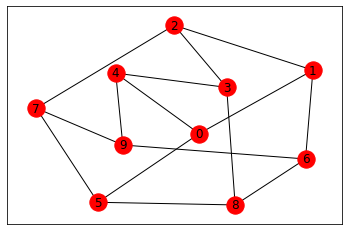

In [38]:
nx.draw_networkx(Petersen, node_color="red")

También podemos podemos pasarle una lista con el color que queremos para cada vértices. Por ejemplo, rellenamos los vértices de 0 a 4 con rojo y de 5 a 9 con azul. Recordar que <code>["red"]*5</code> devuelve una lista con 5 repeticiones de "red" y <code>+</code> es el operador de concatenación de listas.

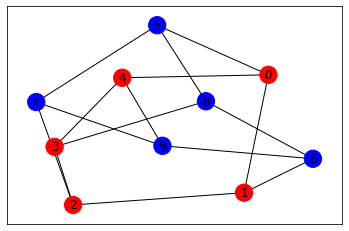

In [39]:
nx.draw_networkx(Petersen, node_color=["red"]*5 + ["blue"]*5)

Incluso, podemos pasar una lista con números en el intervalo $[0,1]$ y la función se ocupa de convertir esos números a colores. Por ejemplo, rellenamos los vértices de 0 a 4 con 0.25 y de 5 a 9 con 0.75.

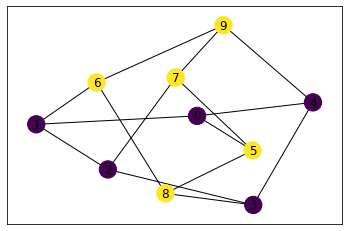

In [40]:
nx.draw_networkx(Petersen, node_color=[0.25]*5 + [0.75]*5)

&#x1f4a1; ¿Y si usamos esto para dibujar los vértices con los colores dados por un coloreo del grafo? &#x1f4a1;

Para ello, tenemos que asignar a cada uno de nuestros colores un número en $[0,1]$. Una forma de hacer esto, es la siguiente. Si en el coloreo $v$ se pinta con $k$, entonces lo vamos a pintar con el número $\frac{k}{|\mathcal C|}$.

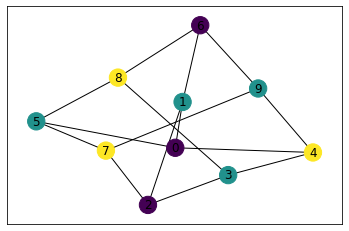

In [41]:
colores = [coloreo_petersen[v]/len(C) for v in coloreo_petersen]
nx.draw_networkx(Petersen, node_color=colores)

¡Uff! Que fea es la disposición (<i>layout</i>) usada para los vértices. Está muy alejada de la forma clásica de dibujar a Petersen. Mejoremos esto... 

La función <code>draw_networkx</code> nos permite especificar la posición que queremos para cada uno de los vértices. La idea es pasarle un diccionario que asocie a cada vértice con una coordenada. 

Para dibujar más lindo a Petersen, podemos ubicar a los vértices sobre dos circunferencias concéntricas, por ejemplo de radios 1 y 2, separados por ángulos de $360/5 = 72$ grados, es decir, $\frac{2\pi}{5}$ radianes.

Entonces, escribamos primero una función <code>coordenada(angulo,radio)</code> que devuelve la intersección entre una circunferencia de radio <code>radio</code> y una recta de pendiente <code>angulo</code> que pasa por el centro de la circunferencia.

In [42]:
import math

def coordenada(angulo,radio):
    x = math.cos(angulo) * radio
    y = math.sin(angulo) * radio
    return (x,y)

Luego, escribimos el diccionario con las coordenadas. Vamos por parte.. El vértice 0 lo ubicamos con un ángulo de $\frac{\pi}{10}$ (18 grados) y radio 2, el vértice 1 lo ubicamos desplazado $\frac{2\pi}{5}$ radianes del anterior, y así sucesivamente hasta el 4. El vértice 5 lo ubicamos con un ángulo de $\frac{\pi}{10}$ (18 grados) y radio 1, el vértice 6 lo ubicamos desplazado $\frac{2\pi}{5}$ radianes del anterior, y así sucesivamente hasta el 9. Es decir, el vértice <code>i</code>  tiene como ángulo:
    
<code>math.pi/10 + i * math.pi * 2/5</code>

Además, necesitamos que los vértices de 0 a 4 tengan radio 2 y los de 5 a 9 radio 1. Esto lo podemos lograr con la siguiente expresión:

<code>1 + math.floor((9-i)/5)</code>

In [43]:
coordenadas = {i: coordenada(math.pi/10 + i * math.pi * 2/5, 1 + math.floor((9-i)/5)) for i in range(0,10)}

Ahora sí, graficamos con nuestras coordenadas.

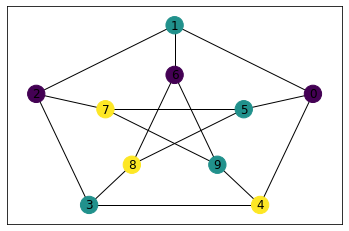

In [44]:
nx.draw_networkx(Petersen, node_color=colores, pos=coordenadas)

¡Una belleza! ¡Arte, arte, arte! &#x1f60d; &#x1f60d;